In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
n_samples = 1000

X,y = make_circles(n_samples, noise=0.03, random_state=42)
print(type(X))
print(type(y))

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [4]:
len(X[:,0])

1000

In [5]:
dataset = pd.DataFrame({'x1':X[:,0], 'x2':X[:,1], 'label':y})
dataset.head()

,x1,x2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [7]:
# Make the Model Class
class CircleModelV1(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)

        return x

In [8]:
# Model Instance
model = CircleModelV1().to(device)
model

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [9]:
# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_true))*100
    return accuracy

In [10]:

# Training  Model
torch.manual_seed(42)
model.train()
epochs = 100

for epoch in range(epochs):
    
    optimizer.zero_grad()
    
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    loss.backward()
    optimizer.step()

    if epoch%10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Accuracy: {accuracy:.2f}")
    
    

Epoch: 0, Loss: 0.69505, Accuracy: 43.62
Epoch: 10, Loss: 0.58635, Accuracy: 77.62
Epoch: 20, Loss: 0.25956, Accuracy: 89.25
Epoch: 30, Loss: 0.03236, Accuracy: 100.00
Epoch: 40, Loss: 0.02347, Accuracy: 99.62
Epoch: 50, Loss: 0.01040, Accuracy: 100.00
Epoch: 60, Loss: 0.00615, Accuracy: 100.00
Epoch: 70, Loss: 0.00430, Accuracy: 100.00
Epoch: 80, Loss: 0.00343, Accuracy: 100.00
Epoch: 90, Loss: 0.00295, Accuracy: 100.00


In [11]:
# Test/Evaluate Model

model.eval()
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    y_pred = torch.round(torch.sigmoid(test_logits))

    loss = loss_fn(test_logits, y_test)
    accuracy = accuracy_fn(y_true=y_test, y_pred=y_pred)

    print(f"Test Loss: {loss:.5f}, Test Accuracy: {accuracy:.2f}")

Test Loss: 0.01381, Test Accuracy: 99.50


In [12]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


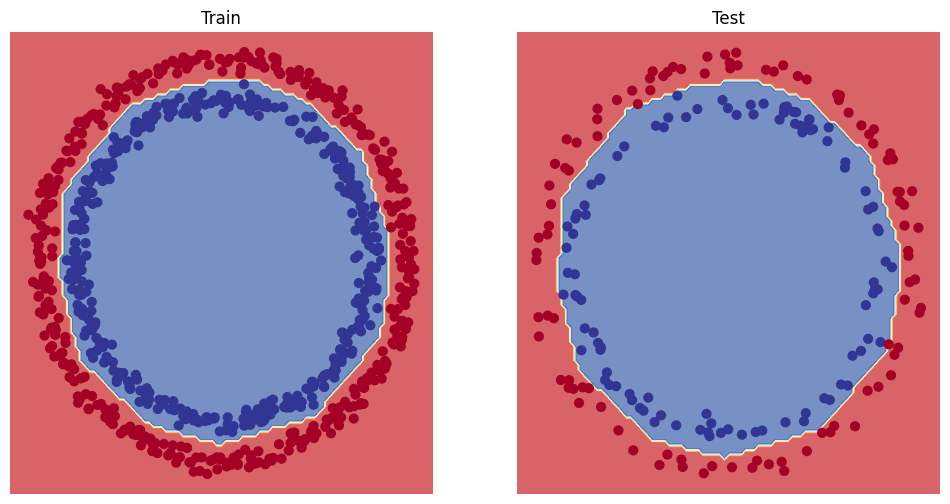

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plt.axis("off")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plt.axis("off")
plot_decision_boundary(model, X_test, y_test)

In [15]:
# Create New Dataset for Linear Regression
start = 0
end = 1
step = 0.01
weight = 0.7
bias = 0.3

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = (weight * X_regression) + bias

In [ ]:
X[:3]

In [ ]:
y[:3]

In [16]:
X_regression_train, X_regression_test, y_regression_train, y_regression_test = train_test_split(X_regression, y_regression, test_size=0.20, random_state=42, shuffle=True)

In [17]:
type(X_regression_train)

torch.Tensor